# Global Interpreter Lock
Python "по-настоящему" поддерживает многопоточность - потоки Python создаются с помощью низкоуровневых функций системы. Однако, специфика языка (а точнее, "эталонного" интерпретатора CPython) накладывает некоторые ограничения. Чтобы не быть голословными, проведём небольшой эксперимент - вычисление числа π.<br>
## Пример: многопоточное вычисление числа π в Python
Сначала зададим функции, которые вычисляют одну функцию рада и значение ряда.<br>

In [18]:
def one(i):
    sign = 1 if i % 2 else -1
    return sign * 4 / (2 * i- 1)

def space(a,b):
    res = 0
    for i in range(a,b):
        res += one(i)
    return res

Напишем декоратор, который будет измерять время выполнения функции

In [19]:
from timeit import default_timer as timer

def measure_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        res = func(*args, **kwargs)
        end = timer()
        print(f'{func.__name__} exectuted for {(end - start):.4f} seconds')
        return res
    return wrapper

Измерим время вычисления числа в одном потоке

In [20]:
series_size = 10000000
@measure_time
def onethreaded():
    result = space(1,series_size)
    print(f'Result: {result:.6f}')
    return result

result = onethreaded()

Result: 3.141593
onethreaded exectuted for 1.9289 seconds


Теперь создадим класс, который занимается вычислением части ряда в потоке

In [21]:
from threading import Thread
class SeriesThread(Thread):
    def __init__(self, begin, end):
        Thread.__init__(self)
        self.begin = begin
        self.end = end
        self.res = 0
        
    def run(self):
        #print(f'Starting calculation {self.begin} - {self.end}')
        self.res = space(self.begin, self.end)
        #print(f'Calculation {self.begin} - {self.end} finished')

После чего сравним время вычисления в одном потоке и в нескольких

In [22]:
@measure_time
def multithreaded(thread_num):
    space = int(series_size / thread_num)
    threads = [SeriesThread(1 + i*space, 1 + (i+1)*space) for i in range(thread_num)]
    [thread.start() for thread in threads]
    [thread.join() for thread in threads]
    res = sum([thread.res for thread in threads])
    print(f'Result for {thread_num} threads: {res:.6f}; ', end = '')
    return res
    
result = [multithreaded(i) for i in range(1, 8)]

Result for 1 threads: 3.141593; multithreaded exectuted for 1.9260 seconds
Result for 2 threads: 3.141593; multithreaded exectuted for 2.4879 seconds
Result for 3 threads: 3.141593; multithreaded exectuted for 2.4456 seconds
Result for 4 threads: 3.141593; multithreaded exectuted for 2.4710 seconds
Result for 5 threads: 3.141593; multithreaded exectuted for 2.3638 seconds
Result for 6 threads: 3.141593; multithreaded exectuted for 2.6014 seconds
Result for 7 threads: 3.141593; multithreaded exectuted for 2.7405 seconds


Результаты, на первый взгляд, отличаются от ожидаемых. Как видно, вычисление в нескольких потоках на самом деле медленнее, чем в одном! Чтобы понять, чем вызвано такое поведение, нужно посмотреть внутреннее устройство интерпретатора CPython

## Особенности работы с памятью CPython
### Счётчик ссылок
Python изначально создавался как язык, который автоматически работает с памятью. Это значит, что нет необходимости явно выделять под объекты ресурсы, и нет необходимости их освобождать по завершении работы. В некоторых средах выполнения (например, JVM или некоторые сторонние интерпретаторы Python) используют механизм под названием <b>сборка мусора</b> - когда память заполняется, среда запускает сборщик мусора. Он по особому алгоритму собирает неиспользуемые объекты, чем особождает память. <br>
Но CPython поступает иначе. Объект в CPython'e выглядит примерно так:<br>
`typedef struct _object {
    unsigned int ob_refcnt;
    struct _typeobject *ob_type;
} object;`<br>
Как видно, каждому объекту поставлено в соответствие число ссылок на объект - `ob_refcnt`. Помимо этого, определены макросы `INCREF`, увеличивающий число ссылок, и `DECREF`, уменьшающий число ссылок. Если число ссылок становится равным 0, память освобождается.
### Проблемы счётчика ссылок
Если приложение - многопоточное, то счётчик ссылок становится разделяемым объектом. Это значит, что к нему может произойти обращение из множества потоков.<br>
Рассмотрим, как реализовано уменьшение счётчика. Компилятор C код вида `ob_refcnt--` приведёт в что-то похожее:<br>
`load ob_refcnt, ax
 decrement ax
 store ax,ob_refcnt`<br>
Здесь и скрывается основная проблема - если два потока, освобождающие ресурс, одновременно считают значение в регистр, уменьшат регистр, и запишут обратно, то реально счётчик уменьшится только на 1. Тогда объект не будет удалён<br>
Но гораздо страшнее другая ситуация: из-за некорректного увеличения объект удаляется раньше нужного. Такой баг на уровне интерпретатора почти невозможно отследить.
### Решение проблемы: Global Interpreter Lock
Для решения вышеописанной проблемы в 1992 году Гвидо Ван Россум создал Global Interpeter Lock, или GIL. Сейчас код, описывающий GIL, находится в [Python/ceval_gil.h](https://github.com/python/cpython/blob/master/Python/ceval_gil.h).<br>
GIL - логическая переменная, доступ к которой охраняется мьютексом. Thread'ы в Python'e построены таким образом, что выполнятся <i>может только поток, владеющий GIL'ом</i>. Каждый поток регулярно выпускает GIL и уведомляет другие потенциальные потоки о том GIL выпущен. Интервал "выпуска" GIL определяется `_PyRuntime.ceval.gil.interval`<br>
`define #FORCE_SWITCHING` устанавливает такой режим работы, что при выпуске GIL его обязательно возьмет другой поток, не владеющий GIL'ом. <br>
Стоит отметить, что система управления GIL в CPython'e неплохо оптимизирована. Например, функции C API, которые (как ожидается) работают относительно долго и при этом потокобезопасны, выпускают GIL во время своей работы. Таким образом, например, операция ввода/вывода фактически передает управление другой ветке. Выходит, что Python неплохо справляется с программами, ориентированными на ввод/вывод.<br>
Кроме того, GIL имеет ещё одно важное преимущество: гарантия, что в C API не произойдёт deadlock'a. Конечно, в Python'e можно получить deadlock - но только в коде, который пишется программистом.
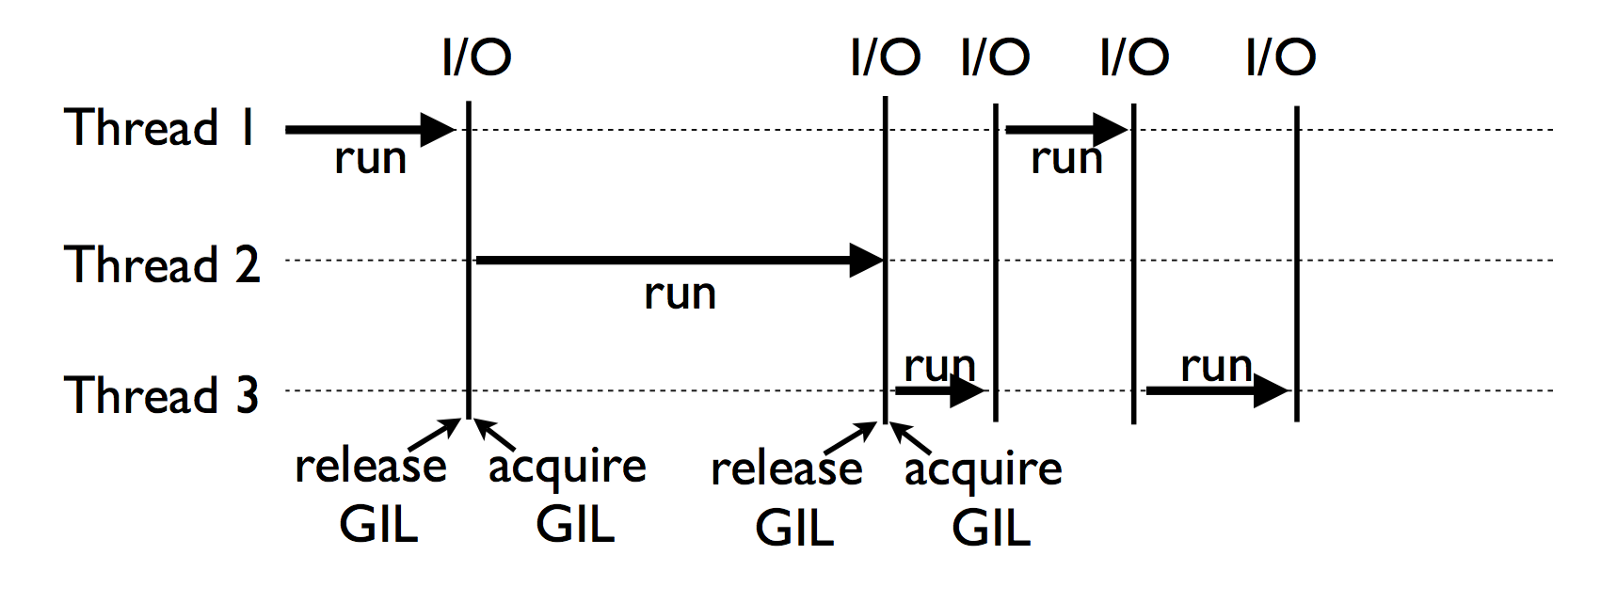
Однако при решении вычислительных задач GIL не даёт нескольким пользовательским потокам выполнять параллельные вычисления. Этим и вызываны результаты, полученные в блоке кода выше
### Попытки избавится от GIL
Гвидо Ван Россум поставил следующее условие: необходимо, чтобы при удалении GIL не упала производительность однопоточного приложения (или завязанного на вводе-выводе многопоточного). Вот некоторые попытки заменить Global Interpreter Lock:
* Поставить мьютекс на ob_refcnt. Оказалось, что ob_refcnt меняется так часто, что производительность Python'a многократно упала
* Atomic-операции на увеличение/уменьшение ob_refcnt. Это оказалось на 30% медленее, чем GIL
* Отказ от счётчика ссылок и использование сборщика мусора. Этот подход реализован в других интерпретаторах Python. Комьюнити CPython отказалось от такого решения, т.к. это потребовало бы огромные изменения в API.

## Повторение эксперимента на других интерпретаторах
### PyPy
Повторим тот же эксперимент, но с использованием PyPy - альтернативного интерпетатора Python. Основные факторы, ускоряющие скорость - использование Just-In-Time (JIT) компиляции и работа с "микропотоками" (microthreads).<br>

In [2]:
path_to_files = '~/PROGRAMMING/ALG_essay'
!pypy3 {path_to_files}/multithreading.py

Result: 3.141593
onethreaded exectuted for 0.0491 seconds
Result for 1 threads: 3.141593; multithreaded exectuted for 0.0397 seconds
Result for 2 threads: 3.141593; multithreaded exectuted for 0.0532 seconds
Result for 3 threads: 3.141593; multithreaded exectuted for 0.0669 seconds
Result for 4 threads: 3.141593; multithreaded exectuted for 0.0664 seconds
Result for 5 threads: 3.141593; multithreaded exectuted for 0.0593 seconds
Result for 6 threads: 3.141593; multithreaded exectuted for 0.0700 seconds
Result for 7 threads: 3.141593; multithreaded exectuted for 0.0726 seconds


Скорость выполнение заметно возрасла! Но увеличения производительности при многопотоковой работе не произошло. Почему? Оказывается, PyPy тоже использует GIL. Таким образом, в данном случае тоже рациональнее использовать один поток.
### Cython
Cython на самом деле не интерпретатор Python, а компилятор. Он компилирует код на Python в код на C и C++. Попробуем запустить эту же программу с помощью Cython

In [13]:
!rm {path_to_files}/cython* {path_to_files}/a.out
!echo '#cython: language_level=3' >> {path_to_files}/cython_multithreading.py
!cat {path_to_files}/multithreading.py >> {path_to_files}/cython_multithreading.py
!cython {path_to_files}/cython_multithreading.py --embed
!gcc -fpic {path_to_files}/cython_multithreading.c -I/usr/include/python3.6 -lpython3.6m -o {path_to_files}/a.out
!{path_to_files}/a.out

Result: 3.141593
onethreaded exectuted for 2.5608 seconds
Result for 1 threads: 3.141593; multithreaded exectuted for 2.5542 seconds
Result for 2 threads: 3.141593; multithreaded exectuted for 2.5317 seconds
Result for 3 threads: 3.141593; multithreaded exectuted for 2.5170 seconds
Result for 4 threads: 3.141593; multithreaded exectuted for 2.5264 seconds
Result for 5 threads: 3.141593; multithreaded exectuted for 2.5289 seconds
Result for 6 threads: 3.141593; multithreaded exectuted for 2.6195 seconds
Result for 7 threads: 3.141593; multithreaded exectuted for 2.6299 seconds


Можно заметить, что в случае Cython использование нескольких потоков всё же повышает производительность. Однако выполнение всё равно медленее, чем в оригинальном интерпретаторе. И намного медленнее приложения, запущенного в PyPy.<br>
Стоит отметить, что данный пример всё же носит чисто академический характер. Так, использование Cython вполне может повысить эффективность управления памятью и производительность - правда, для этого придется использовать специальные конструкции Cython (так как Cython - надмножество над Python). Но это не является предметов данной работы<br>

## "Решение" проблемы GIL: многопроцессные приложения
Из вышесказанного может сложится вывод, что написание "настоящих" параллельных приложений на Python невозможно. Но это далеко не так! На самом деле, есть несколько выходов по реальному распараллеливанию Python. Один из них - использование модуля multiprocessing. Перепишем пример таким образом, чтобы он создавал несколько процессов вместо нескольких потоков:

In [25]:
import multiprocessing

def process_space(a, b, ind, send_end):
    result = space(a,b)
    send_end.send(result)

@measure_time
def multiprocessed(process_num):
    space = int(series_size / process_num)
    pipes = []
    processes = []
    for i in range(process_num):
        recv_end, send_end = multiprocessing.Pipe(False)
        process = multiprocessing.Process(target=process_space, args=(1 + i*space, 1 + (i+1)*space, i, send_end))
        processes.append(process)
        pipes.append(recv_end)
    [process.start() for process in processes]
    [process.join() for process in processes]
    res = sum([pipe.recv() for pipe in pipes])    
    print(f'Result for {process_num} processes: {res:.6f}; ', end = '')
    return res
    
result = [multiprocessed(i) for i in range(1, 8)]

Result for 1 processes: 3.141593; multiprocessed exectuted for 2.1628 seconds
Result for 2 processes: 3.141593; multiprocessed exectuted for 1.0677 seconds
Result for 3 processes: 3.141593; multiprocessed exectuted for 0.7559 seconds
Result for 4 processes: 3.141593; multiprocessed exectuted for 0.5747 seconds
Result for 5 processes: 3.141593; multiprocessed exectuted for 0.6530 seconds
Result for 6 processes: 3.141593; multiprocessed exectuted for 0.6124 seconds
Result for 7 processes: 3.141593; multiprocessed exectuted for 0.5520 seconds


Теперь приложение на Python "по-настоящему" параллельное! Как видно, скорость выполнения перестала расти на 4-х процессах: на компьютере исполнителя 4 ядра. Но и размер кода увеличился: теперь для сообщения между процессами приходится использовать Pipe. Но стоит отметить, что модуль multiprocessing также предоставляет и другие возможности коммуникации между процессами вроде разделяемой памяти<br>
Получается, что Thread'ы в Python бесполезны? На самом деле, только отчасти. Потоки все ещё можно применять в следующих случаях:
* Необходимо логическое распараллеливание приложения
* Потоки вызывают внешные операции вроде загрузки файла или функции C API
Но при решении вычислительных задач многопотоковость только вредит работе. 

# Некоторые продвинутые возможности параллелизма
## Пул потоков
Вышеописанные примеры на Python'e реализованы всё же достаточно громоздко. Но Python представляет набор функций, которые, пусть и не создают никакой добавленной стоимости, значительно сокращают объем кода.
Давайте перепишем многопоточное приложение с использованием пула потоков:

In [46]:
from multiprocessing.dummy import Pool as ThreadPool

@measure_time
def pool_multithreaded(thread_num):
    with ThreadPool(thread_num) as pool:
        local_space = int(series_size / thread_num)
        spaces = [(1 + i*local_space, 1 + (i+1)*local_space) for i in range(thread_num)]
        res = sum(pool.map(lambda space_tuple: space(*space_tuple), spaces))
        pool.close()
        pool.join()
        print(f'Result for {thread_num} threads: {res:.6f}; ', end = '')
        return res

result = [pool_multithreaded(i) for i in range(1, 8)]

Result for 1 threads: 3.141593; pool_multithreaded exectuted for 1.9972 seconds
Result for 2 threads: 3.141593; pool_multithreaded exectuted for 2.5051 seconds
Result for 3 threads: 3.141593; pool_multithreaded exectuted for 2.6438 seconds
Result for 4 threads: 3.141593; pool_multithreaded exectuted for 2.6154 seconds
Result for 5 threads: 3.141593; pool_multithreaded exectuted for 2.6352 seconds
Result for 6 threads: 3.141593; pool_multithreaded exectuted for 2.6787 seconds
Result for 7 threads: 3.141593; pool_multithreaded exectuted for 2.6193 seconds


Данный вариант значительно уменьшает число boilerplate-кода в приложении и предпочтителен, когда решаются простые задачи, связанные с вызовом внешних функций, не держащих GIL. Аналогичные методы доступны и для процессов.
Но нужно заметить, что lambda в качестве функции может принимать только multiprocessing.dummy.Pool. Эта проблема связана с тем, что lambda не относится к Pickable-объектам.

## Concurrent.futures. Executor'ы
Concurrent.futures - модуль, предоставляющий высокоуровневый интерфейс для асинхронного запуска функций.<br>
Executor - абстрактный класс, который предназначен для асинхронного вызова методов. Как и с пулами, существуют ThreadExecutor и ProcessExecutor. Поскольку в предыдушем примеры мы рассматривали потоки, в этом рассмотрим ProcessExecutor

In [45]:
import concurrent.futures

def func(space_tuple):
    return space(*space_tuple)

@measure_time
def executor_multiprocessed(process_num):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        local_space = int(series_size / process_num)
        spaces = [(1 + i*local_space, 1 + (i+1)*local_space) for i in range(process_num)]
        res = sum(executor.map(func, spaces))
        print(f'Result for {process_num} processes: {res:.6f}; ', end = '')

result = [executor_multiprocessed(i) for i in range(1, 8)]

Result for 1 processes: 3.141593; executor_multiprocessed exectuted for 1.8437 seconds
Result for 2 processes: 3.141593; executor_multiprocessed exectuted for 0.9987 seconds
Result for 3 processes: 3.141593; executor_multiprocessed exectuted for 0.7227 seconds
Result for 4 processes: 3.141593; executor_multiprocessed exectuted for 0.6283 seconds
Result for 5 processes: 3.141593; executor_multiprocessed exectuted for 0.6358 seconds
Result for 6 processes: 3.141593; executor_multiprocessed exectuted for 0.5809 seconds
Result for 7 processes: 3.141593; executor_multiprocessed exectuted for 0.5346 seconds


Результаты аналогичны, но кода гораздо меньше - concurrent.futures сам заботится о передаче данных из функции и т.п. <br>
Concurrent.futures имееет и другие функций, их но немного - модуль появился только в Python 3.2. 